In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

from tqdm import tqdm

INPUT_SIZE = 1 * 28 * 28

CONV_SIZE = 5
CONV1_FILTER_NUM = 6
CONV2_FILTER_NUM = 16

POOLING_STRIDE = 2

FLATTEN_INPUT_SIZE = 16 * 4 * 4
HIDDEN_1_SIZE = 120
HIDDEN_2_SIZE = 84
OUTPUT_SIZE = 10

BATCH_SIZE = 60
EPOCH_NUM = 10

transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])]
)

train_set = torchvision.datasets.MNIST(root='./data', download=True, transform=transform)

test_set = torchvision.datasets.MNIST(root='./data', download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE, num_workers=2)

In [8]:
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()

        self.conv1 = nn.Conv2d(1, CONV1_FILTER_NUM, CONV_SIZE)
        self.conv2 = nn.Conv2d(CONV1_FILTER_NUM, CONV2_FILTER_NUM, CONV_SIZE)
        self.fc1 = nn.Linear(FLATTEN_INPUT_SIZE, HIDDEN_1_SIZE)
        self.fc2 = nn.Linear(HIDDEN_1_SIZE, HIDDEN_2_SIZE)
        self.fc3 = nn.Linear(HIDDEN_2_SIZE, OUTPUT_SIZE)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2, stride=2)

        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2, stride=2)

        x = x.view(x.size(0), -1)
        
        x = self.fc1(x)
        x = F.relu(x)

        x = self.fc2(x)
        x = F.relu(x)

        x = self.fc3(x)
        x = F.relu(x)

        return x

net = LeNet5().cuda()
print(net)

LeNet5(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [9]:
criterion = nn.CrossEntropyLoss()

# lr(learning rate) 过大(0.1)导致梯度消失
optimizer = optim.SGD(net.parameters(), lr=5e-3, momentum=0.9)

In [10]:
train_loss_hist = []
test_loss_hist = []

for epoch in tqdm(range(EPOCH_NUM)):
    running_loss = 0.0
    for i, data in enumerate(trainloader):
        images, labels = data
        images = images.cuda()
        labels = labels.cuda()
        outputs = net(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        running_loss += loss.item()
        if(i % 250 == 249):
            with torch.no_grad():
                for test_data in testloader:
                    test_images, test_labels = test_data
                    test_images = test_images.cuda()
                    test_labels = test_labels.cuda()
                    test_outputs = net(test_images)
                    test_loss = criterion(test_outputs, test_labels)
            
            train_loss_hist.append(running_loss / 250)
            test_loss_hist.append(test_loss.item())
            running_loss = 0.0
        
        if(i % 1000 == 999):
            print('step: %d loss: %.3f' % (i, loss))

100%|██████████| 5/5 [03:12<00:00, 38.45s/it]step: 999 loss: 0.448



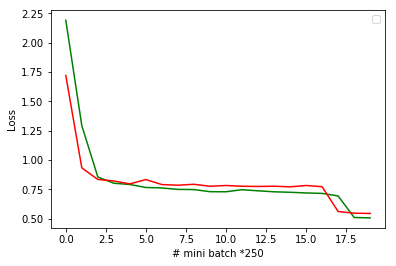

In [11]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(train_loss_hist, color='green')
plt.plot(test_loss_hist, color='red')
plt.legend('train_loss', 'test_loss')
plt.xlabel('# mini batch *250')
plt.ylabel('Loss')

In [12]:
# 测试模型

correct = 0.0
total = 0.0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.cuda()
        labels = labels.cuda()
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)

        correct += (predicted == labels).sum()
        total += labels.size(0)
    
print('准确率：', float(correct) / total)

准确率： 0.79535


In [ ]:
# 准确率： 0.79535